# Monet GAN Project

Intro here ...

In [99]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

Tensorflow Hub  
https://www.tensorflow.org/tutorials/generative/style_transfer#fast_style_transfer_using_tf-hub  
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

## Data Summary

#### Data Source
- Data was imported from the 'I’m Something of a Painter Myself' Kaggle competition.
- 2 folders provided from Kaggle: monet_jpg and photo_jpg. These will be converted to Tensorflow record files so it's easier to do work with

Reference:  
Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

#### Import Datasets

In [109]:
# Paths to data folders and labels file
monet_images_path = './monet_jpg'
photos_images_path  = './photo_jpg'

# Create a list of the file paths to the images in the monet and photos folders
monet_file_paths = glob.glob(os.path.join(monet_images_path, '*.jpg'))
photos_file_paths = glob.glob(os.path.join(photos_images_path, '*.jpg'))

print(f'Count of Monet paintings = {len(monet_file_paths):,}\nCount of photo images = {len(photos_file_paths):,}')

Count of Monet paintings = 300
Count of photo images = 7,038


#### Configure Constant Variables
- Define the exogenous varibles that will be used throughout the modeling and analysis.

In [95]:
# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

# # Image config
# IMG_SIZE = 96 # Target size to resize images to
# CHANNELS = 3  # RGB images
# SAMPLE_SIZE = 55000 # Number of image samples used for training

# # Training config
# BATCH_SIZE = 64 # Training batch size
# AUTOTUNE = tf.data.AUTOTUNE # Let tf.data choose parallelism
# MAX_EPOCHS = 30

# Ignore warnings
# warnings.simplefilter('ignore')

## EDA

#### Similar Looking Pictures  
- ...

Found 300 matched pairs. Showing top 10 by correlation...


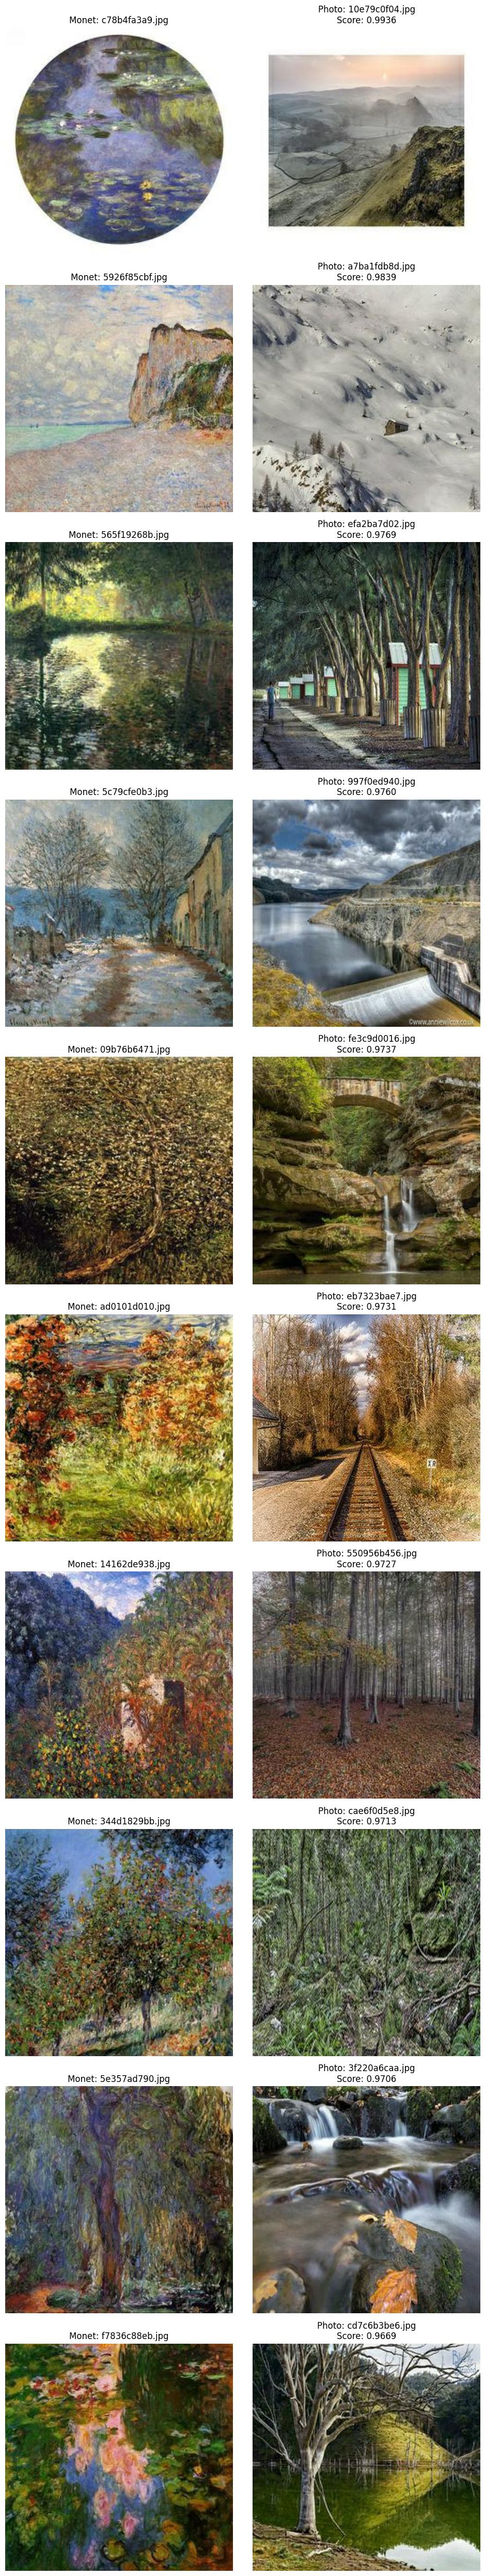

01. Monet: c78b4fa3a9.jpg  <->  Photo: 10e79c0f04.jpg  | Score: 0.9936
02. Monet: 5926f85cbf.jpg  <->  Photo: a7ba1fdb8d.jpg  | Score: 0.9839
03. Monet: 565f19268b.jpg  <->  Photo: efa2ba7d02.jpg  | Score: 0.9769
04. Monet: 5c79cfe0b3.jpg  <->  Photo: 997f0ed940.jpg  | Score: 0.9760
05. Monet: 09b76b6471.jpg  <->  Photo: fe3c9d0016.jpg  | Score: 0.9737
06. Monet: ad0101d010.jpg  <->  Photo: eb7323bae7.jpg  | Score: 0.9731
07. Monet: 14162de938.jpg  <->  Photo: 550956b456.jpg  | Score: 0.9727
08. Monet: 344d1829bb.jpg  <->  Photo: cae6f0d5e8.jpg  | Score: 0.9713
09. Monet: 5e357ad790.jpg  <->  Photo: 3f220a6caa.jpg  | Score: 0.9706
10. Monet: f7836c88eb.jpg  <->  Photo: cd7c6b3be6.jpg  | Score: 0.9669


In [114]:
# Compute per-channel RGB histograms and find best unique matches between Monet and Photo sets
def compute_rgb_hist(image_bgr, bins=256):
    """Return list of 3 normalized histograms for B,G,R channels."""
    hists = []
    for ch in range(3):  # 0=B, 1=G, 2=R
        hist = cv2.calcHist([image_bgr], [ch], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hists.append(hist)
    return hists


def channel_correlation(hist1, hist2):
    """Compare two single-channel histograms using correlation."""
    return cv2.compareHist(hist1.astype('float32'), hist2.astype('float32'), cv2.HISTCMP_CORREL)


def find_best_unique_matches(monet_dir, photo_dir, n_matches=300):
    """Find up to n_matches unique photo matches for Monet images.
    Strategy: precompute histograms for both sets, build a score matrix, then do a greedy unique assignment:
    prefer monet images with highest best-possible score first to reduce collisions.
    """
    # gather file lists (jpg only) and limit monet images to n_matches
    monet_images = sorted([os.path.join(monet_dir, f) for f in os.listdir(monet_dir) if f.lower().endswith('.jpg')])[:n_matches]
    photo_images = sorted([os.path.join(photo_dir, f) for f in os.listdir(photo_dir) if f.lower().endswith('.jpg')])

    if len(monet_images) == 0 or len(photo_images) == 0:
        raise ValueError('No images found in one of the folders')

    # precompute photo histograms once
    photo_hists = []
    for p in photo_images:
        img = cv2.imread(p)
        if img is None:
            continue
        photo_hists.append((p, compute_rgb_hist(img)))

    # precompute monet histograms
    monet_hists = []
    for m in monet_images:
        img = cv2.imread(m)
        if img is None:
            continue
        monet_hists.append((m, compute_rgb_hist(img)))

    # build score matrix (monet x photo)
    scores = []
    for (m_path, m_hist) in monet_hists:
        row = []
        for (p_path, p_hist) in photo_hists:
            ch_scores = [channel_correlation(m_hist[i], p_hist[i]) for i in range(3)]
            row.append(float(np.mean(ch_scores)))
        scores.append(row)
    scores = np.array(scores)

    # greedy unique assignment: order monet images by their best possible match (desc), then pick highest-scoring unassigned photo
    monet_best_scores = scores.max(axis=1)
    monet_order = np.argsort(-monet_best_scores)
    assigned_photos = set()
    matches = []
    for mi in monet_order:
        photo_ranking = np.argsort(-scores[mi])  # indices sorted by descending score
        chosen = None
        for pj in photo_ranking:
            if pj not in assigned_photos:
                chosen = pj
                break
        # if all photos already assigned (rare if more photos than monet), allow reuse of best
        if chosen is None:
            chosen = int(photo_ranking[0])
        assigned_photos.add(chosen)
        matches.append((monet_hists[mi][0], photo_hists[chosen][0], float(scores[mi, chosen])))

    # sort matches by descending correlation score
    matches_sorted = sorted(matches, key=lambda x: -x[2])
    return matches_sorted


# Run matching for 300 pairs and display the top 10 correlated pairs
matches = find_best_unique_matches('/home/ryan-bulger/Monet-GAN/monet_jpg', '/home/ryan-bulger/Monet-GAN/photo_jpg', n_matches=300)
print(f'Found {len(matches):,} matched pairs. Showing top 10 by correlation...')

# Display top 10 side-by-side
top_k = min(10, len(matches))
fig, axes = plt.subplots(top_k, 2, figsize=(10, 5 * top_k))
for idx in range(top_k):
    monet_path, photo_path, score = matches[idx]
    m_img = cv2.imread(monet_path)
    p_img = cv2.imread(photo_path)
    # convert BGR->RGB for matplotlib
    if m_img is not None:
        m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
    if p_img is not None:
        p_img = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
    axm = axes[idx, 0] if top_k > 1 else axes[0]
    axp = axes[idx, 1] if top_k > 1 else axes[1]
    if m_img is not None:
        axm.imshow(m_img)
    axm.set_title(f'Monet: {os.path.basename(monet_path)}')
    axm.axis('off')
    if p_img is not None:
        axp.imshow(p_img)
    axp.set_title(f'Photo: {os.path.basename(photo_path)}\nScore: {score:.4f}')
    axp.axis('off')
plt.tight_layout()
plt.show()

# Print the top 10 filenames and scores for reference
for i, (m, p, s) in enumerate(matches[:top_k], 1):
    print(f'{i:02d}. Monet: {os.path.basename(m)}  <->  Photo: {os.path.basename(p)}  | Score: {s:.4f}')


#### Create Training, Validation, and Test Datasets
- ...

In [ ]:
# Load training dataset labels
train_labels_df = pd.read_csv('./train/train_labels.csv')

# Take random samples from the train_labels_df (to reduce training time)
# train_labels_df = train_labels_df.sample(SAMPLE_SIZE)
# test_file_paths = random.sample(test_file_paths, SAMPLE_SIZE)

# Training-Validation split
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, random_state=42, stratify=train_labels_df['label'])

# Create file paths list after train-validation split
train_paths = ['./train/' + id + '.tif' for id in train_df['id']]
val_paths = ['./train/' + id + '.tif' for id in val_df['id']]

# Create label vectors after train-validation split
training_labels = train_df['label'].values
validation_labels = val_df['label'].values

# Numpy function used to read and resize images
def _read_and_resize(path):
    path = path.decode('utf-8')
    img = tiff.imread(path)       
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img.astype(np.float32)

#Function to load and preprocess each image
def load_image(path, label):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    label = tf.cast(label, tf.int32)
    return img, label

#Function to load and preprocess each image
def load_train_image(path):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    return img

# Create training and validation tf.data.Dataset instances
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, training_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, validation_labels))

# Create the test set
test_ds = tf.data.Dataset.from_tensor_slices((test_file_paths))

# Create training dataset
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nTraining dataset of {len(training_labels):,} images has been created.')

# Create validation dataset
val_ds = (
    val_ds
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nValidation dataset of {len(validation_labels):,} images has been created.')

# Create validation dataset
test_ds = (
    test_ds
    .map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nTesting dataset of {len(test_file_paths):,} images has been created.')

In [ ]:
# def _bytes_feature(value):
#     if isinstance(value, type(tf.constant(0))):
#         value = value.numpy()
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def image_to_tfexample(image_string, label):
#     feature = {
#         'image': _bytes_feature(image_string),
#         'label': _bytes_feature(label.encode('utf-8'))
#     }
#     return tf.train.Example(features=tf.train.Features(feature=feature))

# def convert_images_to_tfrecords(input_dir, output_dir, label):
#     os.makedirs(output_dir, exist_ok=True)
#     image_files = [f for f in os.listdir(input_dir) if f.lower().endswith('.jpg')]

#     for i, filename in enumerate(image_files, 1):
#         image_path = os.path.join(input_dir, filename)
#         tfrec_name = os.path.splitext(filename)[0] + '.tfrec'
#         tfrec_path = os.path.join(output_dir, tfrec_name)

#         with open(image_path, 'rb') as f:
#             image_bytes = f.read()

#         example = image_to_tfexample(image_bytes, label)
#         with tf.io.TFRecordWriter(tfrec_path) as writer:
#             writer.write(example.SerializeToString())

#         if i % 1000 == 0 or i == len(image_files):
#             print(f'Processed {i}/{len(image_files)} images into {output_dir}')

# # Define folders
# photo_jpg_dir = 'photo_jpg'
# monet_jpg_dir = 'monet_jpg'
# photo_tfrec_dir = 'photo_tfrec'
# monet_tfrec_dir = 'monet_tfrec'

# # Run conversions
# convert_images_to_tfrecords(photo_jpg_dir, photo_tfrec_dir, 'photo')
# convert_images_to_tfrecords(monet_jpg_dir, monet_tfrec_dir, 'monet')

# print('All .jpg files have been converted to individual .tfrec files.')

## Modeling

## Hyperparameter Tuning

## Other Models

## Results & Analysis

## Conclusion